## Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the packages

In [ ]:
%tensorflow_version 1.x
%pip install scipy==1.1.0

TensorFlow 1.x selected.
     |████████████████████████████████| 31.2MB 95kB/s 
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: lucid 0.3.10 has requirement numpy<=1.19, but you'll have numpy 1.19.5 which is incompatible.
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import sys

%matplotlib inline
sys.path.insert(0, "/content/drive/My Drive/Neural Style Transfer")

In [ ]:
from nst_utils import *

## Downloading pre-trained model from Kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Neural Style Transfer"

In [ ]:
%cd /content/drive/My Drive/Neural Style Transfer

/content/drive/My Drive/Neural Style Transfer


In [ ]:
!kaggle datasets download -d teksab/imagenetvggverydeep19mat

 98% 501M/510M [00:05<00:00, 86.7MB/s]
100% 510M/510M [00:05<00:00, 92.6MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  imagenetvggverydeep19mat.zip
  inflating: imagenet-vgg-verydeep-19.mat  


## Loading the pretrained model

In [ ]:
model = load_vgg_model("/content/drive/My Drive/Neural Style Transfer/pretrained-model/imagenet-vgg-verydeep-19.mat")
# print(model)

## Computing the content cost

In [ ]:
def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled, a_C_unrolled))) * (1 / (4 * n_H * n_W * n_C))
    
    return J_content

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


## Computing the Style matrix

In [ ]:
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


##Computing the Style cost

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190279


## The Style Weights

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [ ]:
def compute_style_cost(model, STYLE_LAYERS):
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

## Computing the Total Cost

In [ ]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [ ]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [ ]:
content_image = scipy.misc.imread("/content/drive/My Drive/Neural Style Transfer/images/my_content.jpeg")
content_image = reshape_and_normalize_image(content_image)
#print(content_image.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [ ]:
style_image = scipy.misc.imread("/content/drive/My Drive/Neural Style Transfer/images/my_style.jpg")
style_image = reshape_and_normalize_image(style_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


## Generating the noisy image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


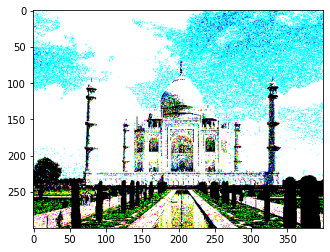

In [ ]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

## Loading saved model

In [ ]:
model = load_vgg_model("/content/drive/My Drive/Neural Style Transfer/pretrained-model/imagenet-vgg-verydeep-19.mat")

In [ ]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

In [ ]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
J = total_cost(J_content, J_style)

In [ ]:
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

## Defining the model

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
      
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("/content/drive/My Drive/Neural Style Transfer/output/" + str(i) + ".png", generated_image)
            
    save_image('/content/drive/My Drive/Neural Style Transfer/output/generated_image.jpg', generated_image)
    
    return generated_image

## Running the model

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 8961923000.0
content cost = 7618.1245
style cost = 224046180.0
Iteration 20 :
total cost = 2243565600.0
content cost = 16324.939
style cost = 56085056.0
Iteration 40 :
total cost = 1043580000.0
content cost = 19301.867
style cost = 26084676.0
Iteration 60 :
total cost = 621470400.0
content cost = 20464.305
style cost = 15531643.0
Iteration 80 :
total cost = 428425540.0
content cost = 21240.314
style cost = 10705328.0
Iteration 100 :
total cost = 329556160.0
content cost = 21819.762
style cost = 8233448.5
Iteration 120 :
total cost = 271388200.0
content cost = 22269.426
style cost = 6779138.0
Iteration 140 :
total cost = 232329280.0
content cost = 22578.98
style cost = 5802587.0
Iteration 160 :
total cost = 203647950.0
content cost = 22823.643
style cost = 5085493.0
Iteration 180 :
total cost = 181135310.0
content cost = 23041.582
style cost = 4522622.5


array([[[[ 3.62659812e+00,  5.34104462e+01,  6.41103134e+01],
         [ 5.37642097e+00,  8.11011658e+01,  5.85898819e+01],
         [ 3.02939625e+01,  1.09906113e+02,  8.84160004e+01],
         ...,
         [ 5.97074966e+01,  9.71547470e+01,  8.46869659e+01],
         [ 5.21845245e+01,  9.64307175e+01,  1.06075874e+02],
         [ 6.56175842e+01,  1.88061218e+02,  1.33849213e+02]],

        [[ 4.57036197e-02,  7.09869461e+01,  5.62317085e+01],
         [ 3.35330048e+01,  8.77005615e+01,  1.62672913e+02],
         [ 9.95450363e+01,  8.55325165e+01,  1.05588753e+02],
         ...,
         [ 5.66355095e+01,  1.48574188e+02,  9.93915405e+01],
         [ 5.69355774e+01,  1.10565140e+02,  9.98556366e+01],
         [ 3.54575424e+01,  6.59714508e+01,  9.05730515e+01]],

        [[ 2.62094250e+01,  1.08953384e+02,  1.18936897e+02],
         [ 8.89357910e+01,  5.37747383e+01,  9.16176224e+01],
         [ 1.14272911e+02,  8.11929169e+01,  9.02695312e+01],
         ...,
         [ 6.10504608e+0